In [1]:
import tensorflow as tf
import numpy as np
from grad_cam import get_gradcam_heatmap, combine_image_and_heatmap

import matplotlib.pyplot as plt

In [2]:
# Load model
model = tf.keras.models.load_model("../training/model/trained_model.h5")

2022-05-13 18:07:53.857187: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-13 18:07:54.463105: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6435 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:18:00.0, compute capability: 7.5


In [3]:
# Read data
ds_test = tf.data.experimental.load('../cache/ds_test.tf')

In [4]:
# Evaluate model
model.compile(loss='categorical_crossentropy', metrics='accuracy')
results = model.evaluate(ds_test, verbose=True)
print(f"Test loss {results[0]}, Test acc {results[1]}")

2022-05-13 18:07:56.053079: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201
2022-05-13 18:07:56.659442: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


3/3 [==============================] - 3s 114ms/step - loss: 0.0078 - accuracy: 0.9987
Test loss 0.00776272127404809, Test acc 0.9986522793769836


In [5]:
# Model predict
y_test = [label for image,label in list(ds_test.unbatch().as_numpy_iterator())]
y_test_idx = tf.argmax(y_test, axis=1)
predictions = model.predict(ds_test)
predictions_idx = tf.argmax(predictions, axis=1)

In [6]:
# Confusion matrix
conf_mat = tf.math.confusion_matrix(y_test_idx, predictions_idx)
print(conf_mat)

tf.Tensor(
[[422   1   0]
 [  0 533   0]
 [  0   1 527]], shape=(3, 3), dtype=int32)


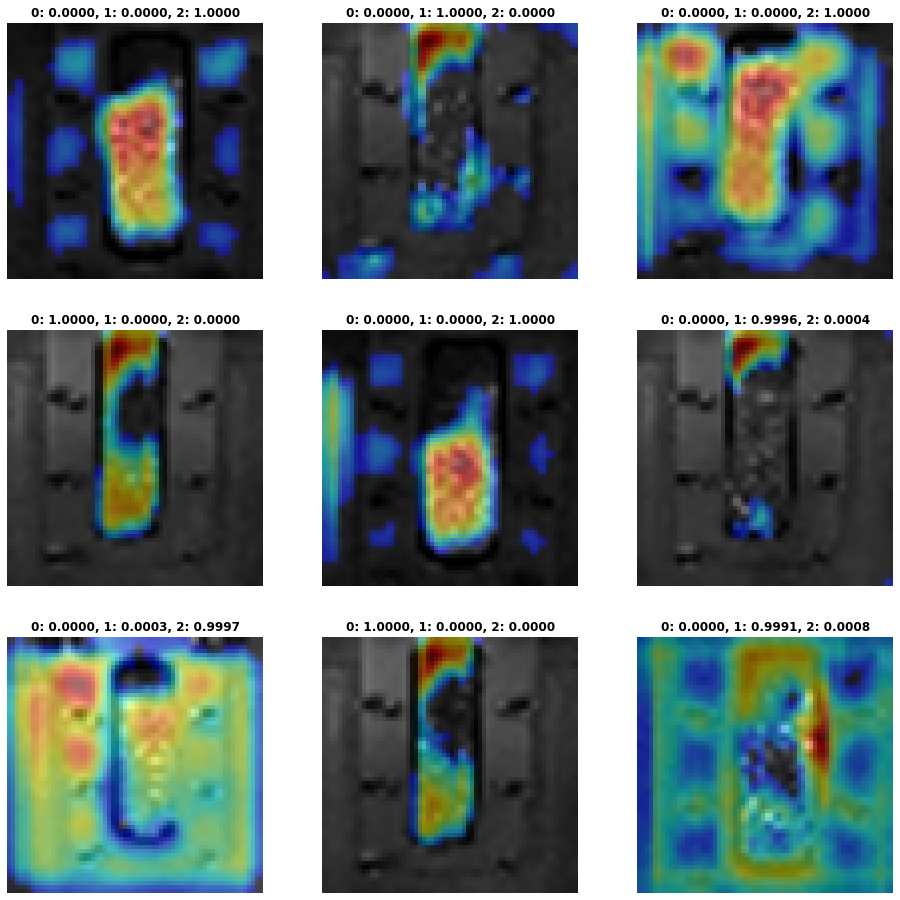

In [9]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(16, 16))
axs = axs.flatten()

for data_point, ax in zip(ds_test.unbatch().take(9), axs):
    image, label = data_point
    image = image.numpy()
    label = label.numpy()
    img_array = np.expand_dims(image, axis=0)

    # Print what the top predicted class is
    preds = model.predict(img_array)

    # Generate class activation heatmap
    heatmap = get_gradcam_heatmap(image, model, 'conv2d_1')
    superimposed_image = combine_image_and_heatmap(image, heatmap, alpha=0.5)

    # Display heatmap
    ax.imshow(superimposed_image)
    font_axis_publish = {
          'color':  'black',
          'weight': 'bold',
          'size': 12,
    }
    ax.axis('off')
    probs = preds.tolist()[0]
    label_title = f'0: {probs[0]:0.4f}, 1: {probs[1]:0.4f}, 2: {probs[2]:0.4f}'
    ax.set_title(label_title, fontdict=font_axis_publish)
